In [1]:
# Import necessary libraries for data manipulation and analysis
import numpy as np # Numerical operations
import pandas as pd # Data manipulation
from datetime import datetime, timedelta # Date operations

#Import necessary libraries for transformations
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
from scipy.stats import skew, kurtosis

# Import libraries for plotting and visualization
import matplotlib.pyplot as plt # Matplotlib for basic plotting
import seaborn as sns # Seaborn for enhanced visualization
import plotly.express as px # Plotly for interactive plots

# Import libraries for time series analysis and modeling
from statsmodels.tsa.stattools import adfuller # Augmented Dickey-Fuller Test for stationarity check
from statsmodels.tsa.stattools import kpss # Kwiatkowski-Phillips-Schmidt-Shin Test for stationarity check
from statsmodels.tsa.statespace.sarimax import SARIMAX # SARIMAX model for time series forecasting
from statsmodels.tsa.seasonal import seasonal_decompose # Seasonal decomposition for trend, seasonal, and residual components
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima #SARIMAX using pmdarima

# Import necessary libraries for computing acf and pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For autocorrelation and partial autocorrelation plots
from statsmodels.tsa.stattools import acf, pacf  # For computing autocorrelation and partial autocorrelation

import joblib



SARIMAX for Luzon
DATA PREPROCESSING

In [2]:
labels_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon\train_labels_transformed.csv'
data_csv = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon\train_data_transformed.csv'
test_data_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/test_data.csv'
test_labels_csv=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/test_labels.csv'
transformed_data=r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/data_transformed.csv'
complete_data = r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/LUZ_Daily_Complete.csv'

transformed_train_data = pd.read_csv(data_csv)
transformed_train_labels = pd.read_csv(labels_csv)
transformed_data = pd.read_csv(transformed_data)

test_data = pd.read_csv(test_data_csv)
test_labels = pd.read_csv(test_labels_csv)

complete_data_df = pd.read_csv(complete_data)
gwap = complete_data_df[['GWAP']]
lwap = complete_data_df[['LWAP']]



In [3]:
train_size = int(len(transformed_train_labels))  
test_size = int(len(test_data))

date_range = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')
date_df = pd.DataFrame(date_range, columns=['Date'])

train_date = date_df[:train_size]
test_date = date_df[train_size:]

#Resetting the Index
train_date = train_date.reset_index(drop=True)
test_date = test_date.reset_index(drop=True)


In [4]:
#Preparing the dataframes
transformed_train_labels.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)
labels_columns = ['GWAP', 'LWAP']
labels_train = pd.DataFrame(transformed_train_labels, columns = labels_columns)
labels_test = pd.DataFrame(test_labels, columns = labels_columns)
transformed_train_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)
data_columns = ['FLOW_LUZ', 'Hourly Demand', 'TMAX_Cubi Point', 'TMAX_NAIA', 'TMIN_NAIA', 'TMAX_Science Garden', 'TMAX_SanJose', 'TMIN_SanJose', 'TMAX_Tayabas', 'TMIN_Tayabas', 'TMAX_CLSU', 'TMIN_CLSU', 'TMAX_Ambulong', 'TMAX_Casiguran', 'TMIN_Casiguran', 'TMAX_Clark', 'TMIN_Clark', 'TMAX_Calapan', 'TMIN_Calapan', 'GWAP', 'LWAP', 'TMIN_Cubi Point', 'TMIN_Science Garden', 'TMIN_Ambulong', 'RESERVE_GWAP_Fr', 'RESERVE_GWAP_Ru', 'RESERVE_GWAP_Rd', 'RESERVE_GWAP_Dr', 'RAINFALL_Cubi Point', 'RAINFALL_NAIA', 'RAINFALL_Science Garden', 'RAINFALL_San Jose', 'RAINFALL_Tayabas', 'RAINFALL_CLSU', 'RAINFALL_Tanay', 'TMAX_Tanay', 'TMIN_Tanay', 'RAINFALL_Ambulong', 'RAINFALL_Casiguran', 'RAINFALL_Clark', 'RAINFALL_Calapan']
data_train = pd.DataFrame(transformed_train_data)
data_test = pd.DataFrame(test_data, columns = data_columns)

transformed_data.rename(columns={'0':'FLOW_LUZ','1':'Hourly Demand', '2':'TMAX_Cubi Point','3':'TMAX_NAIA','4':'TMIN_NAIA','5':'TMAX_Science Garden','6':'TMAX_SanJose','7':'TMIN_SanJose','8':'TMAX_Tayabas','9':'TMIN_Tayabas','10':'TMAX_CLSU','11':'TMIN_CLSU','12':'TMAX_Ambulong','13':'TMAX_Casiguran','14':'TMIN_Casiguran','15':'TMAX_Clark','16':'TMIN_Clark','17':'TMAX_Calapan','18':'TMIN_Calapan','19':'GWAP','20':'LWAP','21':'TMIN_Cubi Point','22':'TMIN_Science Garden','23':'TMIN_Ambulong','24':'RESERVE_GWAP_Fr','25':'RESERVE_GWAP_Ru','26':'RESERVE_GWAP_Rd','27':'RESERVE_GWAP_Dr','28':'RAINFALL_Cubi Point','29':'RAINFALL_NAIA','30':'RAINFALL_Science Garden','31':'RAINFALL_San Jose','32':'RAINFALL_Tayabas','33':'RAINFALL_CLSU','34':'RAINFALL_Tanay','35':'TMAX_Tanay','36':'TMIN_Tanay','37':'RAINFALL_Ambulong','38':'RAINFALL_Casiguran','39':'RAINFALL_Clark','40':'RAINFALL_Calapan'}, inplace=True)


In [5]:
#lagging the transformed data
transformed_data = transformed_data.shift(1)
transformed_data = transformed_data.fillna(0)

#Removing GWAP and LWAP
transformed_exog = transformed_data.drop(columns=['GWAP','LWAP'])

#Preparing the exog datasets
train_exog = transformed_exog[:train_size]
test_exog = transformed_exog[train_size:]



In [6]:
#Preparing transformed GWAP datasets
GWAP_train = labels_train['GWAP']
GWAP_train = pd.concat([train_date,GWAP_train], axis=1)
GWAP_train.set_index('Date', inplace=True)
GWAP_train.index = pd.to_datetime(GWAP_train.index)
GWAP_train.index.freq='D'
GWAP_train = GWAP_train.squeeze()


GWAP_test = labels_test['GWAP']
GWAP_test = pd.concat([test_date,GWAP_test], axis=1)
GWAP_test.set_index('Date', inplace=True)
GWAP_test.index = pd.to_datetime(GWAP_test.index)
GWAP_test.index.freq='D'
GWAP_test = GWAP_test.squeeze()

#Preparing original GWAP datasets
GWAP = pd.concat([date_df,gwap], axis=1)
GWAP.set_index('Date', inplace=True)
GWAP.index = pd.to_datetime(GWAP.index)
GWAP.index.freq='D'
GWAP = GWAP.squeeze()

GWAP_test_inversed = GWAP[train_size:]




#Preparing the transformed LWAP datasets
LWAP_train = labels_train['LWAP']
LWAP_train = pd.concat([train_date,LWAP_train], axis=1)
LWAP_train.set_index('Date', inplace=True)
LWAP_train.index = pd.to_datetime(LWAP_train.index)
LWAP_train.index.freq='D'
LWAP_train = LWAP_train.squeeze()

LWAP_test = labels_test['LWAP']
LWAP_test = pd.concat([test_date,LWAP_test], axis=1)
LWAP_test.set_index('Date', inplace=True)
LWAP_test.index = pd.to_datetime(LWAP_test.index)
LWAP_test.index.freq='D'
LWAP_test = LWAP_test.squeeze()

#Preparing the original LWAP datasets

LWAP = pd.concat([date_df,lwap], axis=1)
LWAP.set_index('Date', inplace=True)
LWAP.index = pd.to_datetime(LWAP.index)
LWAP.index.freq='D'
LWAP = LWAP.squeeze()

LWAP_test_inversed = LWAP[train_size:]



#Preparing the exogenous datasets
exog_train = pd.concat([train_date,train_exog], axis=1)
exog_train.set_index('Date', inplace=True)

test_exog = pd.DataFrame(test_exog)
test_exog = test_exog.reset_index()
exog_test = pd.concat([test_date,test_exog], axis=1)
exog_test.set_index('Date', inplace=True)
exog_test = exog_test.drop(columns=['index'])

In [7]:
#Applying the inverse transformations
#Loading inverse transformations for Luzon

minmax_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/minmax_scaler.pkl')
boxcox_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/boxcox_pipeline.pkl')
yeojohnson_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/yeojohnson_pipeline.pkl')
boxcoxy_fit_loaded = joblib.load(r'C:\Users\Jojie\Desktop\School\Senior\Thesis\SARIMAX\Luzon/boxcox_pipeliney.pkl')

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator PowerTransformer from version 1.5.2 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\Jojie\A

In [8]:
#Plotting Train LWAP ang GWAP
# Create the line plot
gwap_plot = px.line(GWAP_train, x=GWAP_train.index, y='GWAP')
lwap_plot = px.line(LWAP_train, x=LWAP_train.index, y='LWAP')
# Set the title using the ticker value
gwap_plot.update_layout(title=f"Luzon GWAP")
lwap_plot.update_layout(title=f"Luzon LWAP")
# Display the plot
gwap_plot.show()
lwap_plot.show()

In [9]:
def perform_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Check initial stationarity
    for i in range(max_differences):
        adf_p_value = adf_test(data)
        kpss_p_value = kpss_test(data)

        # If ADF p-value is less than 0.05 and KPSS p-value is greater than 0.05, it's stationary
        if adf_p_value < 0.05 and kpss_p_value > 0.05:
            print(f"Data is stationary after differencing {i} times.")
            return data

        # If not stationary, apply differencing
        data = data.diff().dropna()

    print(f"Data could not be made stationary after {max_differences} differencing operations.")
    return data

#same test for dataframe
def perform_df_differencing(data, max_differences=3):
    # Function to check if data is stationary using ADF
    def adf_test(series):
        result = adfuller(series)
        return result[1]  # p-value

    # Function to check if data is stationary using KPSS 
    def kpss_test(series):
        result = kpss(series, regression='c')
        return result[1]  # p-value

    # Store in new DataFrame
    diff_exog = pd.DataFrame(index=data.index)

    # Check each column in the DataFrame
    for column in data.columns:
        series = data[column].copy()  # Copy the series to avoid modifying the original

        for i in range(max_differences):
            adf_p_value = adf_test(series)
            kpss_p_value = kpss_test(series)

            # If stationary, break the loop and store the series
            if adf_p_value < 0.05 and kpss_p_value > 0.05:
                print(f"Column '{column}' is stationary after differencing {i} times.")
                diff_exog[column] = series  # Store the stationary series
                break

            # If not stationary, apply differencing
            if i < max_differences - 1:  # Don't drop NA on the last iteration
                series = series.diff().dropna()

        else:  # This else corresponds to the for-loop
            print(f"Column '{column}' could not be made stationary after {max_differences} differencing operations.")
            diff_exog[column] = series  # Store the last differenced result

    return diff_exog


In [10]:
#Checking for stationarity in GWAP data
perform_differencing(GWAP_train)
perform_differencing(LWAP_train)



Data is stationary after differencing 0 times.
Data is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:9: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




Date
2022-01-01    0.258105
2022-01-02    0.314556
2022-01-03    0.418724
2022-01-04    0.501099
2022-01-05    0.787813
                ...   
2023-08-03    0.317026
2023-08-04    0.432209
2023-08-05    0.410919
2023-08-06    0.415499
2023-08-07    0.426566
Freq: D, Name: LWAP, Length: 584, dtype: float64

In [11]:
diff_exog_train = perform_df_differencing(exog_train)
diff_exog_train = diff_exog_train.fillna(0)

C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\24

Column 'FLOW_LUZ' is stationary after differencing 0 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'TMAX_Cubi Point' is stationary after differencing 0 times.
Column 'TMAX_NAIA' is stationary after differencing 0 times.
Column 'TMIN_NAIA' is stationary after differencing 0 times.
Column 'TMAX_Science Garden' is stationary after differencing 0 times.
Column 'TMAX_SanJose' is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\24

Column 'TMIN_SanJose' is stationary after differencing 1 times.
Column 'TMAX_Tayabas' is stationary after differencing 0 times.
Column 'TMIN_Tayabas' is stationary after differencing 1 times.
Column 'TMAX_CLSU' is stationary after differencing 1 times.
Column 'TMIN_CLSU' is stationary after differencing 1 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\24

Column 'TMAX_Ambulong' is stationary after differencing 0 times.
Column 'TMAX_Casiguran' is stationary after differencing 1 times.
Column 'TMIN_Casiguran' is stationary after differencing 1 times.
Column 'TMAX_Clark' is stationary after differencing 0 times.
Column 'TMIN_Clark' is stationary after differencing 0 times.
Column 'TMAX_Calapan' is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Column 'TMIN_Calapan' is stationary after differencing 1 times.
Column 'TMIN_Cubi Point' is stationary after differencing 0 times.
Column 'TMIN_Science Garden' is stationary after differencing 1 times.
Column 'TMIN_Ambulong' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Fr' is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\24

Column 'RESERVE_GWAP_Ru' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Rd' is stationary after differencing 1 times.
Column 'RESERVE_GWAP_Dr' is stationary after differencing 1 times.
Column 'RAINFALL_Cubi Point' is stationary after differencing 1 times.
Column 'RAINFALL_NAIA' is stationary after differencing 0 times.
Column 'RAINFALL_Science Garden' is stationary after differencing 0 times.
Column 'RAINFALL_San Jose' is stationary after differencing 0 times.
Column 'RAINFALL_Tayabas' is stationary after differencing 0 times.
Column 'RAINFALL_CLSU' is stationary after differencing 1 times.
Column 'RAINFALL_Tanay' is stationary after differencing 0 times.
Column 'TMAX_Tanay' is stationary after differencing 0 times.
Column 'TMIN_Tanay' is stationary after differencing 1 times.
Column 'RAINFALL_Ambulong' is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\24

Column 'RAINFALL_Casiguran' is stationary after differencing 1 times.
Column 'RAINFALL_Clark' is stationary after differencing 0 times.
Column 'RAINFALL_Calapan' is stationary after differencing 0 times.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




In [12]:
diff_exog_test = perform_df_differencing(exog_test)
diff_exog_test = diff_exog_test.fillna(0)


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\24

Column 'FLOW_LUZ' is stationary after differencing 1 times.
Column 'Hourly Demand' is stationary after differencing 1 times.
Column 'TMAX_Cubi Point' is stationary after differencing 1 times.
Column 'TMAX_NAIA' is stationary after differencing 0 times.
Column 'TMIN_NAIA' is stationary after differencing 1 times.
Column 'TMAX_Science Garden' is stationary after differencing 0 times.
Column 'TMAX_SanJose' is stationary after differencing 1 times.
Column 'TMIN_SanJose' is stationary after differencing 1 times.
Column 'TMAX_Tayabas' is stationary after differencing 1 times.
Column 'TMIN_Tayabas' is stationary after differencing 0 times.
Column 'TMAX_CLSU' is stationary after differencing 0 times.
Column 'TMIN_CLSU' is stationary after differencing 1 times.
Column 'TMAX_Ambulong' is stationary after differencing 1 times.
Column 'TMAX_Casiguran' is stationary after differencing 1 times.
Column 'TMIN_Casiguran' is stationary after differencing 1 times.
Column 'TMAX_Clark' is stationary after 

C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\2411308064.py:37: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


C:\Users\Jojie\AppData\Local\Temp\ipykernel_20648\24

In [13]:
#Checking GWAP for seasonality
from scipy.stats import kruskal

GWAP_train_weekly=pd.DataFrame(GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
GWAP_train_weekly['day_of_week'] = GWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_GWAP_train_weekly = [group['GWAP'].values for name, group in GWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_GWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 13.75404219114398
p-value: 0.032507628998916446
There are significant differences between the weekly groups.


In [14]:
#Checking LWAP for seasonality
LWAP_train_weekly=pd.DataFrame(GWAP_train)
#Kruskal Wallis Test

#Extract day of the week
LWAP_train_weekly['day_of_week'] = LWAP_train_weekly.index.dayofweek

# Group data by day of the week
grouped_LWAP_train_weekly = [group['GWAP'].values for name, group in LWAP_train_weekly.groupby('day_of_week')]

#Running the Kruskal Wallis Test
statistic, p_value = kruskal(*grouped_LWAP_train_weekly)

print('Kruskal-Wallis test statistic:', statistic)
print('p-value:', p_value)

if p_value < 0.05:
    print("There are significant differences between the weekly groups.")
else:
    print("No significant differences found between the weekly groups.")

Kruskal-Wallis test statistic: 13.75404219114398
p-value: 0.032507628998916446
There are significant differences between the weekly groups.


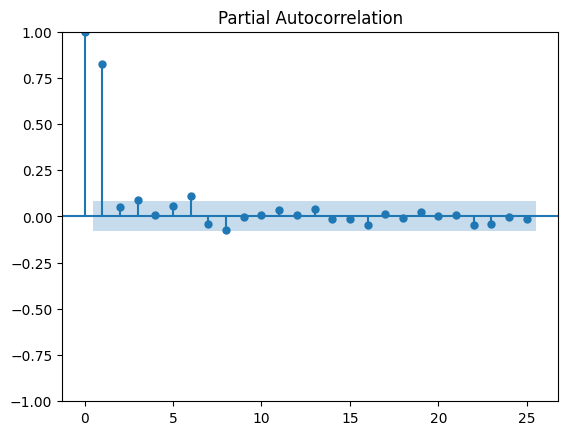

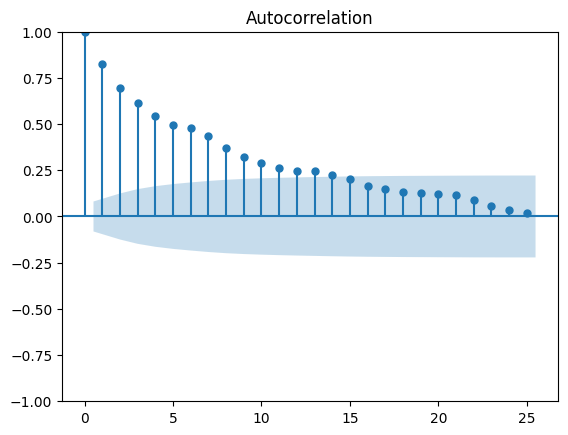

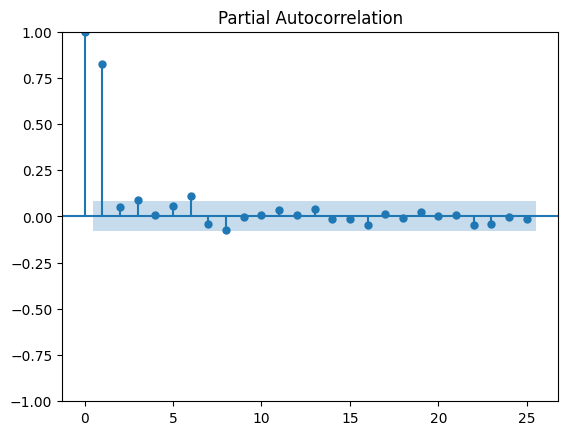

In [15]:
# Visualize autocorrelation using plot_acf
plot_acf(GWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(GWAP_train, lags=25, alpha=0.05)

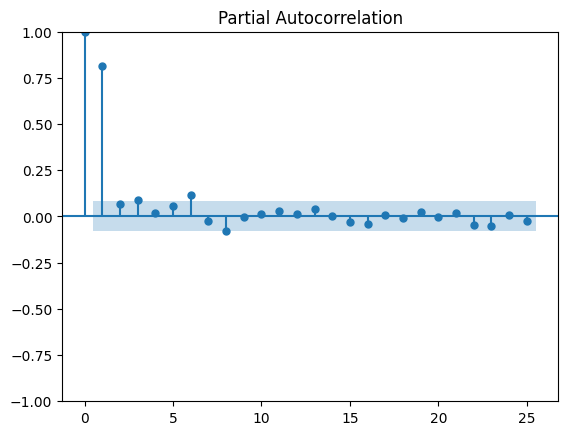

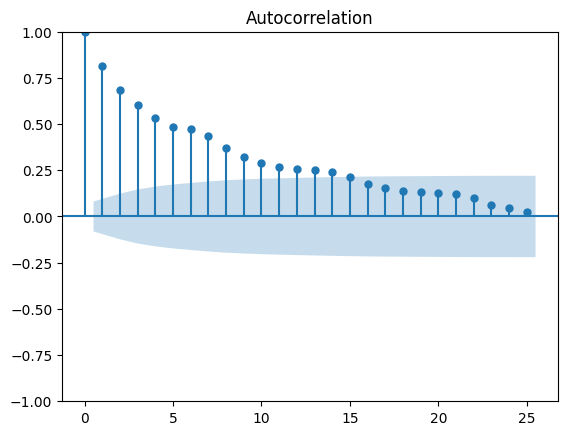

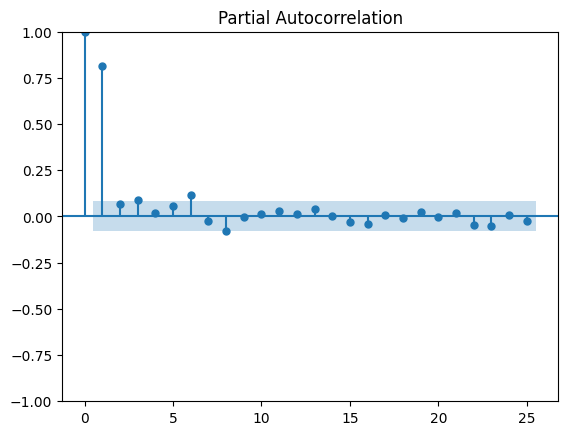

In [16]:
#LUZON LWAP
# Visualize autocorrelation using plot_acf
plot_acf(LWAP_train, lags=25, alpha=0.05)  # Plot autocorrelation using plot_acf with confidence interval
# Generate a partial autocorrelation plot
plot_pacf(LWAP_train, lags=25, alpha=0.05)

Forecast using statsmodels

In [17]:
#weekly seasonality
GWAP_sarimax_7 = auto_arima(GWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=13, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=diff_exog_train, iter=1000, method='powell')

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-1019.602, Time=0.07 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-1020.747, Time=1.08 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-1018.783, Time=1.03 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-1020.800, Time=0.25 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-1019.181, Time=0.77 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-1017.423, Time=1.28 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-1018.846, Time=0.70 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=-1017.216, Time=1.48 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=5.01 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-1033.009, Time=0.49 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-1034.434, Time=0.79 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-1032.617, Time=1.38 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-1034.567, Time=0.85 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-1033.297, Time=0.94 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-1031.726, Time=1.41 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-1032.803, Time=1.40 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-1031.512, Time=1.53 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=5.67 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=-1048.248, Time=0.63 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=-1047.364, Time=0.95 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=-1045.376, Time=1.41 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=-1047.376, Time=1.15 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=-1045.640, Time=1.27 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(1,0,2)[7] intercept   : AIC=-1043.869, Time=1.48 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=-1045.403, Time=1.18 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(2,0,1)[7] intercept   : AIC=-1043.737, Time=1.53 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(0,0,0)[7] intercept   : AIC=-1049.375, Time=0.71 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(0,0,1)[7] intercept   : AIC=-1048.210, Time=1.29 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(0,0,2)[7] intercept   : AIC=-1046.212, Time=1.74 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(1,0,0)[7] intercept   : AIC=-1048.207, Time=0.86 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-1046.342, Time=1.52 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(2,0,0)[7] intercept   : AIC=-1046.215, Time=2.35 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,4)(0,0,0)[7] intercept   : AIC=-1051.551, Time=1.44 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,4)(0,0,1)[7] intercept   : AIC=-1051.014, Time=2.23 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=-1050.989, Time=1.57 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,5)(0,0,0)[7] intercept   : AIC=-1057.080, Time=0.96 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-1028.298, Time=0.04 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-1029.947, Time=0.86 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=-1028.097, Time=1.22 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-1030.074, Time=0.42 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-1028.753, Time=0.90 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=-1027.121, Time=1.22 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=-1028.261, Time=0.80 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=-1026.893, Time=1.47 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=6.50 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-1065.372, Time=1.09 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-1069.450, Time=3.48 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=-1067.655, Time=3.26 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-1069.683, Time=2.80 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=-1068.357, Time=5.00 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=-1066.641, Time=4.81 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=-1067.824, Time=4.25 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=-1066.258, Time=2.95 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=-1064.348, Time=1.89 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=-1068.391, Time=3.30 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=-1066.710, Time=5.11 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=-1068.661, Time=3.35 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=-1067.452, Time=4.83 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=-1066.835, Time=4.75 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(0,0,0)[7] intercept   : AIC=-1049.525, Time=0.71 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(0,0,1)[7] intercept   : AIC=-1048.723, Time=1.87 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(1,0,0)[7] intercept   : AIC=-1048.714, Time=1.78 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,4)(0,0,0)[7] intercept   : AIC=-1050.650, Time=1.62 sec

Best model:  ARIMA(1,1,1)(1,0,0)[7] intercept
Total fit time: 120.708 seconds


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -0.994533
         Iterations: 16
         Function evaluations: 5839


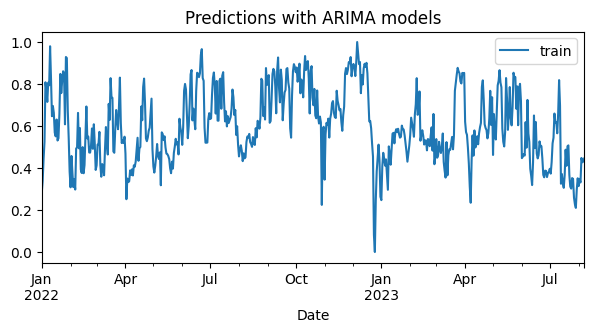

In [18]:
#Using statsmodels

gwap_model_weekly = SARIMAX(endog = GWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(1,0,0,7))
fitted_gwap_model_weekly=gwap_model_weekly.fit(method='powell', maxiter=300)

gwap_train_predict = fitted_gwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [19]:
fitted_gwap_model_weekly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               GWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                 580.808
Date:                            Fri, 27 Dec 2024   AIC                          -1075.615
Time:                                    18:16:59   BIC                           -887.783
Sample:                                01-01-2022   HQIC                         -1002.402
                                     - 08-07-2023                                         
Covariance Type:                              opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
FLOW_LUZ                    0.0037      0.035      0.107      0.915      -0.064       0.072
Hourly Demand               0.0399      0.041      0.973      0.330      -0.040       0.120
TMAX_Cubi Point             0.0229      0.048      0.474      0.635      -0.072       0.118
TMAX_NAIA                  -0.0994      0.052     -1.924      0.054      -0.201       0.002
TMIN_NAIA                   0.0794      0.043      1.860      0.063      -0.004       0.163
TMAX_Science Garden         0.0792      0.046      1.715      0.086      -0.011       0.170
TMAX_SanJose                0.0063      0.037      0.169      0.866      -0.067       0.080
TMIN_SanJose                0.0444      0.031      1.453      0.146      -0.015       0.104
TMAX_Tayabas                0.0164      0.046      0.358      0.721      -0.073       0.106
TMIN_Tayabas               -0.0630      0.023     -2.715      0.007      -0.108      -0.018
TMAX_CLSU                   0.0081      0.032      0.251      0.802      -0.055       0.072
TMIN_CLSU                   0.0196      0.025      0.782      0.434      -0.030       0.069
TMAX_Ambulong               0.0001      0.043      0.003      0.997      -0.084       0.084
TMAX_Casiguran              0.0108      0.024      0.446      0.656      -0.037       0.058
TMIN_Casiguran              0.0370      0.028      1.311      0.190      -0.018       0.092
TMAX_Clark                 -0.0083      0.056     -0.149      0.881      -0.118       0.101
TMIN_Clark                  0.0003      0.048      0.007      0.995      -0.093       0.094
TMAX_Calapan                0.0051      0.043      0.119      0.905      -0.079       0.089
TMIN_Calapan               -0.0433      0.028     -1.547      0.122      -0.098       0.012
TMIN_Cubi Point             0.0069      0.049      0.139      0.889      -0.090       0.103
TMIN_Science Garden         0.0037      0.027      0.138      0.890      -0.049       0.057
TMIN_Ambulong              -0.0229      0.026     -0.899      0.369      -0.073       0.027
RESERVE_GWAP_Fr            -0.0317      0.029     -1.095      0.274      -0.089       0.025
RESERVE_GWAP_Ru             0.0162      0.029      0.566      0.571      -0.040       0.072
RESERVE_GWAP_Rd            -0.0596      0.041     -1.444      0.149      -0.141       0.021
RESERVE_GWAP_Dr            -0.0037      0.012     -0.320      0.749      -0.026       0.019
RAINFALL_Cubi Point         0.0174      0.011      1.547      0.122      -0.005       0.039
RAINFALL_NAIA               0.0720      0.059      1.221      0.222      -0.044       0.188
RAINFALL_Science Garden    -0.0090      0.018     -0.510      0.610      -0.044       0.026
RAINFALL_San Jose           0.0041      0.019      0.214      0.831      -0.033       0.041
RAINFALL_Tayabas           -0.0190      0.017     -1.110      0.267      -0.052       0.015
RAINF

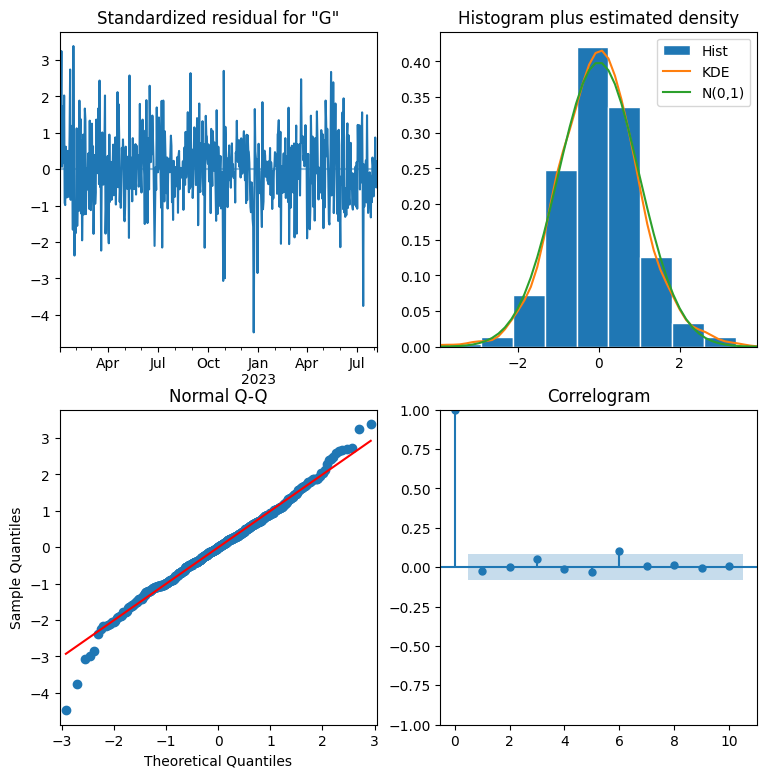

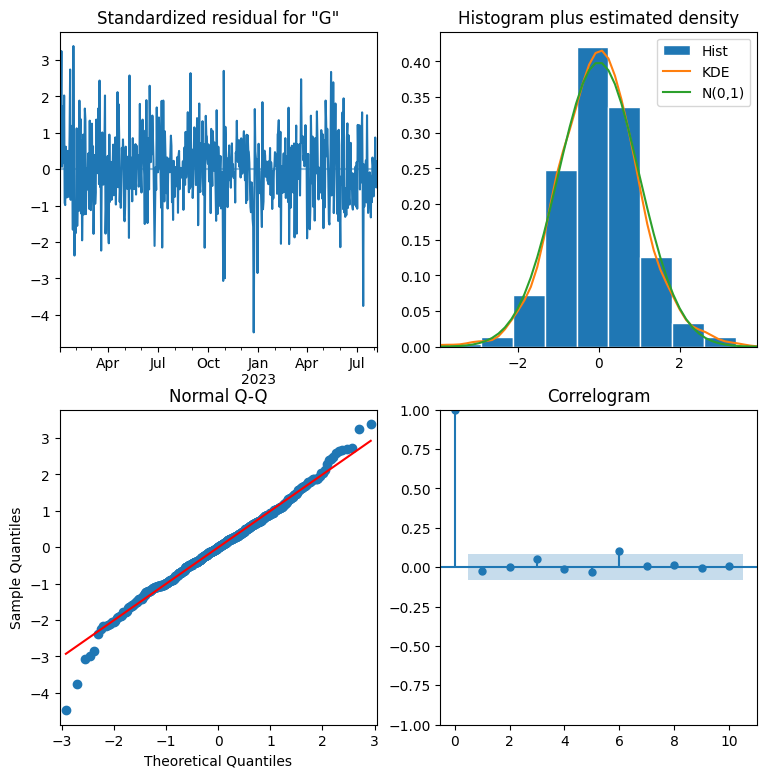

In [20]:
fitted_gwap_model_weekly.plot_diagnostics(figsize=(9,9))


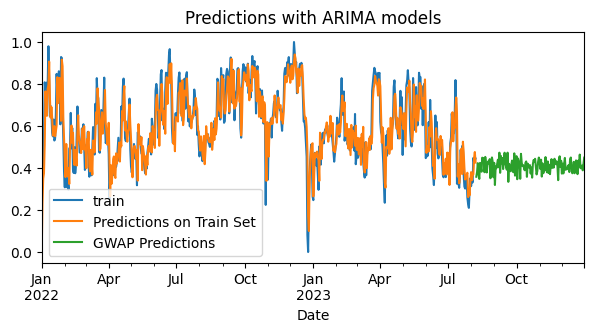

In [21]:
gwap_test_predict = fitted_gwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
GWAP_train.plot(ax=ax, label='train')
gwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
gwap_test_predict.plot(ax=ax, label='GWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [22]:
LWAP_sarimax_7 = auto_arima(LWAP_train, 
                            start_p=0, start_d=0, start_q=0,
                            max_p=1, max_d=2, max_q=14, seasonal=True, m=7, start_P=0, start_D=0, start_Q=0,
                            error_action='warn', trace=True,
                            suppress_warnings=True, stepwise=False,
                            exog=diff_exog_train, iter=1000, method='powell')

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecatio

 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=-975.031, Time=0.13 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=-976.667, Time=1.08 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=-975.102, Time=1.13 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=-976.879, Time=0.25 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=-975.885, Time=0.60 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-974.404, Time=1.20 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=-975.386, Time=0.51 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=-974.178, Time=0.94 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.99 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=-993.443, Time=0.40 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=-995.365, Time=0.97 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=-994.136, Time=1.13 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=-995.674, Time=0.74 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=-995.103, Time=0.85 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=-994.017, Time=1.33 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=-994.620, Time=1.27 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=-993.813, Time=1.28 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=inf, Time=5.47 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=-1009.065, Time=0.44 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,0,1)[7] intercept   : AIC=-1008.384, Time=0.86 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(0,0,2)[7] intercept   : AIC=-1006.750, Time=1.33 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(1,0,0)[7] intercept   : AIC=-1008.458, Time=0.72 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=-1007.146, Time=1.10 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(1,0,2)[7] intercept   : AIC=-1005.849, Time=1.60 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=-1006.932, Time=1.29 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,2)(2,0,1)[7] intercept   : AIC=-1005.691, Time=1.64 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(0,0,0)[7] intercept   : AIC=-1010.854, Time=0.63 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(0,0,1)[7] intercept   : AIC=-1009.912, Time=1.07 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(0,0,2)[7] intercept   : AIC=-1008.132, Time=1.56 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(1,0,0)[7] intercept   : AIC=-1009.962, Time=1.41 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=-1008.429, Time=1.30 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,3)(2,0,0)[7] intercept   : AIC=-1008.240, Time=2.11 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,4)(0,0,0)[7] intercept   : AIC=-1013.558, Time=1.07 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,4)(0,0,1)[7] intercept   : AIC=-1013.445, Time=2.11 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,4)(1,0,0)[7] intercept   : AIC=-1013.493, Time=1.60 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(0,1,5)(0,0,0)[7] intercept   : AIC=-1018.583, Time=0.99 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=-987.165, Time=0.04 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=-989.449, Time=0.70 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=-988.160, Time=1.13 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=-989.771, Time=0.39 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-989.197, Time=0.84 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=-987.957, Time=1.26 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=-988.621, Time=1.25 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=-987.728, Time=1.32 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=5.39 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=-1025.667, Time=1.15 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,0,1)[7] intercept   : AIC=-1030.281, Time=3.33 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(0,0,2)[7] intercept   : AIC=-1029.109, Time=3.18 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=-1030.783, Time=2.97 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=8.79 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=-1028.750, Time=4.78 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=-1029.505, Time=4.86 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,1)(2,0,1)[7] intercept   : AIC=-1028.291, Time=3.82 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=-1025.256, Time=1.49 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=-1029.773, Time=2.69 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=-1028.798, Time=3.89 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=-1030.296, Time=2.70 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=8.22 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=-1029.455, Time=4.54 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(0,0,0)[7] intercept   : AIC=-1026.535, Time=3.57 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(0,0,1)[7] intercept   : AIC=-1029.598, Time=7.78 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,3)(1,0,0)[7] intercept   : AIC=-1030.046, Time=6.41 sec


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



 ARIMA(1,1,4)(0,0,0)[7] intercept   : AIC=-1012.893, Time=1.25 sec

Best model:  ARIMA(1,1,1)(1,0,0)[7] intercept
Total fit time: 133.879 seconds


C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Optimization terminated successfully.
         Current function value: -0.963082
         Iterations: 16
         Function evaluations: 5835


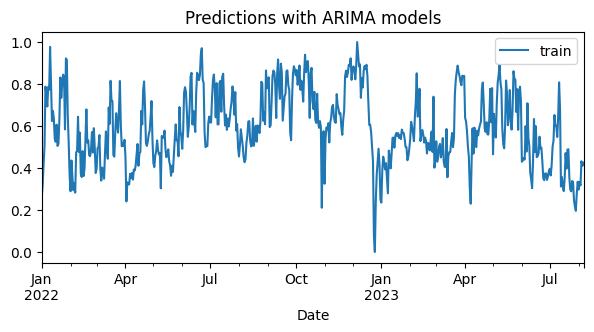

In [23]:
lwap_model_weekly = SARIMAX(endog = LWAP_train, exog = diff_exog_train, order=(1, 1, 1), seasonal_order=(1,0,0,7))
fitted_lwap_model_weekly=lwap_model_weekly.fit(method='powell', maxiter=300)
#Check fit on train set
lwap_train_predict = fitted_lwap_model_weekly.predict(start='2022-01-01', end='2023-08-07', exog=diff_exog_train)
fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
ax.set_title('Predictions with ARIMA models')
ax.legend()

In [24]:
fitted_lwap_model_weekly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                               LWAP   No. Observations:                  584
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 7)   Log Likelihood                 562.440
Date:                            Fri, 27 Dec 2024   AIC                          -1038.880
Time:                                    18:20:59   BIC                           -851.048
Sample:                                01-01-2022   HQIC                          -965.667
                                     - 08-07-2023                                         
Covariance Type:                              opg                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
FLOW_LUZ                    0.0028      0.036      0.079      0.937      -0.068       0.074
Hourly Demand               0.0512      0.043      1.204      0.229      -0.032       0.134
TMAX_Cubi Point             0.0343      0.049      0.700      0.484      -0.062       0.130
TMAX_NAIA                  -0.0981      0.053     -1.836      0.066      -0.203       0.007
TMIN_NAIA                   0.0826      0.044      1.872      0.061      -0.004       0.169
TMAX_Science Garden         0.0785      0.048      1.629      0.103      -0.016       0.173
TMAX_SanJose                0.0081      0.039      0.208      0.835      -0.068       0.084
TMIN_SanJose                0.0456      0.032      1.427      0.154      -0.017       0.108
TMAX_Tayabas                0.0270      0.048      0.565      0.572      -0.067       0.121
TMIN_Tayabas               -0.0691      0.024     -2.875      0.004      -0.116      -0.022
TMAX_CLSU                   0.0178      0.034      0.527      0.598      -0.048       0.084
TMIN_CLSU                   0.0187      0.026      0.709      0.479      -0.033       0.071
TMAX_Ambulong              -0.0055      0.044     -0.126      0.900      -0.091       0.080
TMAX_Casiguran              0.0065      0.025      0.257      0.797      -0.043       0.056
TMIN_Casiguran              0.0257      0.029      0.898      0.369      -0.030       0.082
TMAX_Clark                 -0.0121      0.058     -0.208      0.835      -0.126       0.102
TMIN_Clark                  0.0035      0.049      0.072      0.942      -0.093       0.100
TMAX_Calapan                0.0008      0.044      0.018      0.986      -0.086       0.087
TMIN_Calapan               -0.0411      0.029     -1.424      0.155      -0.098       0.015
TMIN_Cubi Point             0.0131      0.051      0.256      0.798      -0.087       0.113
TMIN_Science Garden         0.0097      0.028      0.346      0.729      -0.045       0.065
TMIN_Ambulong              -0.0263      0.027     -0.982      0.326      -0.079       0.026
RESERVE_GWAP_Fr            -0.0432      0.030     -1.449      0.147      -0.102       0.015
RESERVE_GWAP_Ru             0.0134      0.029      0.455      0.649      -0.044       0.071
RESERVE_GWAP_Rd            -0.0766      0.042     -1.841      0.066      -0.158       0.005
RESERVE_GWAP_Dr            -0.0038      0.012     -0.320      0.749      -0.027       0.020
RAINFALL_Cubi Point         0.0153      0.011      1.341      0.180      -0.007       0.038
RAINFALL_NAIA               0.0631      0.059      1.061      0.289      -0.053       0.180
RAINFALL_Science Garden    -0.0083      0.018     -0.453      0.650      -0.044       0.028
RAINFALL_San Jose          -0.0007      0.020     -0.036      0.971      -0.039       0.038
RAINFALL_Tayabas           -0.0225      0.018     -1.282      0.200      -0.057       0.012
RAINF

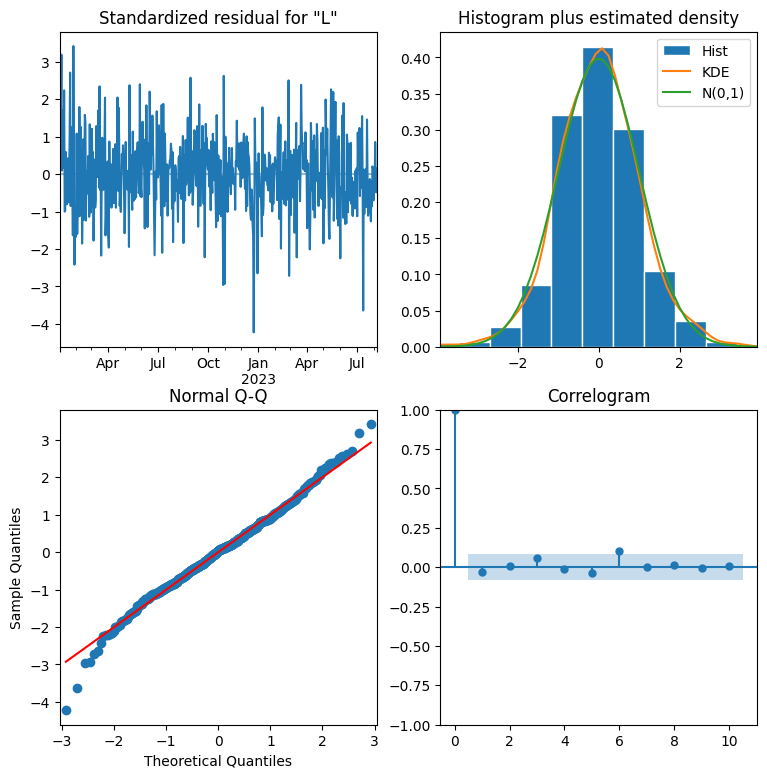

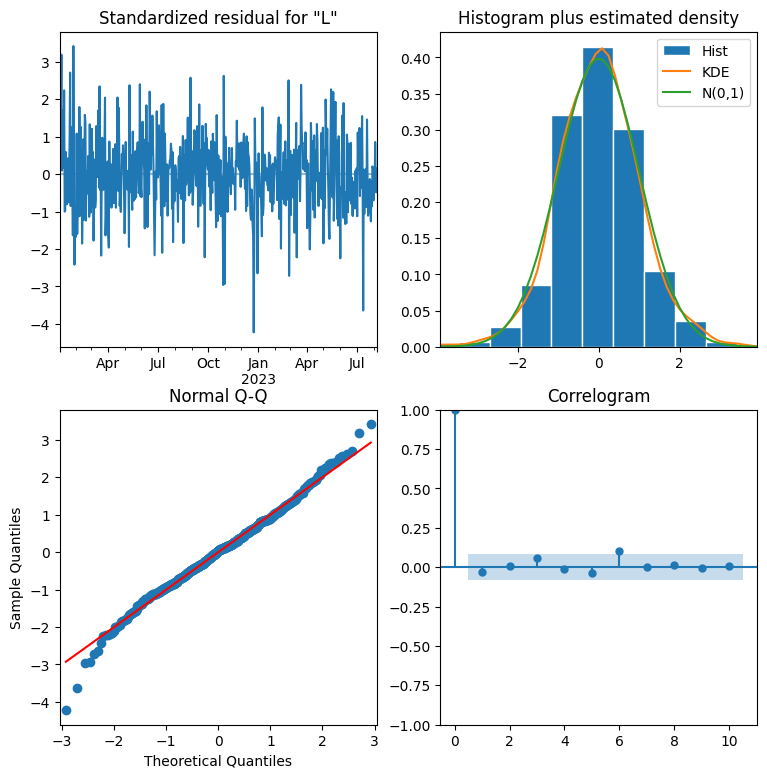

In [25]:
fitted_lwap_model_weekly.plot_diagnostics(figsize=(9,9))

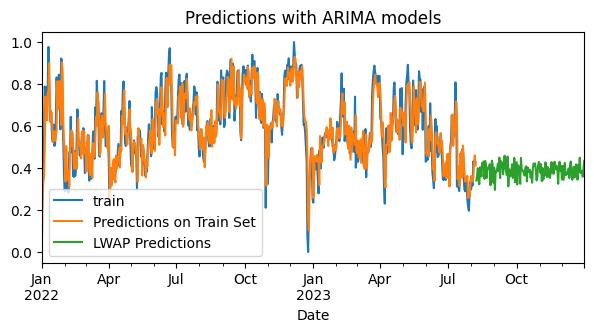

In [26]:
#Predict using LWAP mdodel and plot predictions
lwap_test_predict = fitted_lwap_model_weekly.predict(start='2023-8-8', end='2023-12-31', exog=diff_exog_test, dynamic=True)

fig, ax = plt.subplots(figsize=(7, 3))
LWAP_train.plot(ax=ax, label='train')
lwap_train_predict.plot(ax=ax, label='Predictions on Train Set')
lwap_test_predict.plot(ax=ax, label='LWAP Predictions')
ax.set_title('Predictions with ARIMA models')
ax.legend()

Applying inverse transformations - non-rolling

In [28]:
all_predictions = pd.concat([gwap_test_predict, lwap_test_predict], axis=1)
all_predictions_inverse=boxcoxy_fit_loaded.inverse_transform(all_predictions)
all_predictions_inverse

C:\Users\Jojie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning:

X does not have valid feature names, but PowerTransformer was fitted with feature names



array([[3865.64394541, 4005.1106955 ],
       [4099.44857946, 4258.26475485],
       [4591.8337814 , 4712.52147984],
       [4021.44690939, 4085.87324825],
       [3765.88733745, 3822.77187419],
       [4609.05248653, 4778.43050303],
       [4347.23827812, 4417.99935523],
       [4116.19448471, 4221.71815411],
       [4939.7914395 , 5078.74293608],
       [4653.54683842, 4792.08152054],
       [4901.32420774, 5164.56482813],
       [4087.33795468, 4091.98262543],
       [4991.75097864, 5198.55326926],
       [4618.79465916, 4824.89741296],
       [4076.13906343, 4144.02424502],
       [4518.68890681, 4675.05567479],
       [4700.31058037, 4774.60184025],
       [4572.44848666, 4691.83625093],
       [4844.27638431, 4974.84253185],
       [3795.47971831, 3779.77111732],
       [4487.38313241, 4686.31071035],
       [4953.37019671, 5226.78648399],
       [4680.09964859, 4882.73731045],
       [3842.10968019, 3891.59903587],
       [4610.34645872, 4741.19584241],
       [3501.02161571, 35

In [30]:
all_predictions_inverse_df = pd.DataFrame(all_predictions_inverse)
all_predictions_inverse_df.rename(columns={'0': 'GWAP', '1': 'LWAP'}, inplace=True)

GWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 0], columns=['GWAP'])
GWAP_predictions_inverse = pd.concat([test_date,GWAP_predictions_inverse], axis=1)
GWAP_predictions_inverse.set_index('Date', inplace=True)
GWAP_predictions_inverse.index = pd.to_datetime(GWAP_predictions_inverse.index)
GWAP_predictions_inverse.index.freq='D'
GWAP_predictions_inverse = GWAP_predictions_inverse.squeeze()

LWAP_predictions_inverse = pd.DataFrame(all_predictions_inverse[:, 1], columns=['LWAP'])
LWAP_predictions_inverse = pd.concat([test_date,LWAP_predictions_inverse], axis=1)
LWAP_predictions_inverse.set_index('Date', inplace=True)
LWAP_predictions_inverse.index = pd.to_datetime(LWAP_predictions_inverse.index)
LWAP_predictions_inverse.index.freq='D'
LWAP_predictions_inverse = LWAP_predictions_inverse.squeeze()

In [34]:
# Calculate MAE for the Luzon GWAP test set
mae_test = mean_absolute_error(GWAP_test_inversed, GWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Luzon GWAP test set
mse_test = mean_squared_error(GWAP_test_inversed, GWAP_predictions_inverse)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")
GWAP.plot(ax=ax, label='Original Data')
GWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon GWAP Predictions')
ax.legend()
plt.show()

Mean Absolute Error (MAE) on Test Set: 1690.791510504591
Root Mean Squared Error (RMSE) on Test Set: 3046.399460012488


Mean Absolute Error (MAE) on Test Set: 1825.3521527399757
Root Mean Squared Error (RMSE) on Test Set: 3282.481635742439


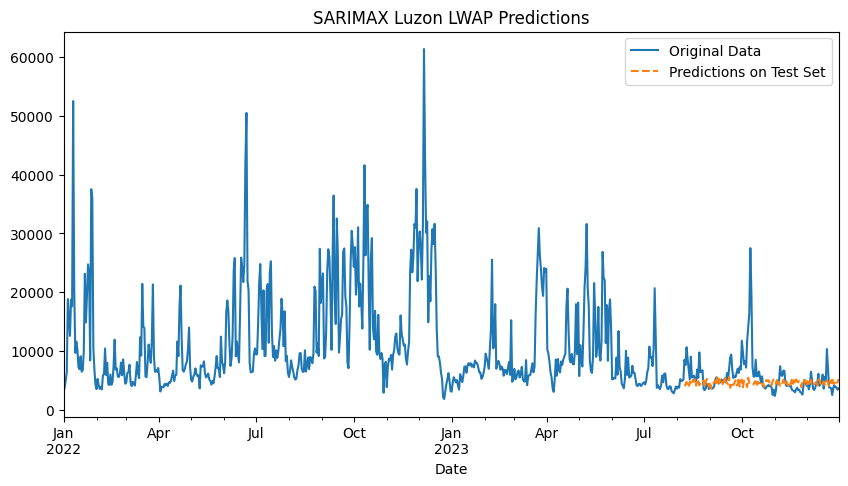

In [35]:
# Calculate MAE for the Luzon LWAP test set
mae_test = mean_absolute_error(LWAP_test_inversed, LWAP_predictions_inverse)
print(f"Mean Absolute Error (MAE) on Test Set: {mae_test}")

# Calculate RMSE for the Luzon LWAP test set
mse_test = mean_squared_error(LWAP_test_inversed, LWAP_predictions_inverse)
rmse_test = np.sqrt(mse_test)
print(f"Root Mean Squared Error (RMSE) on Test Set: {rmse_test}")

# Plot predictions
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original Data')
LWAP_predictions_inverse.plot(ax=ax, label='Predictions on Test Set', linestyle='--')
ax.set_title('SARIMAX Luzon LWAP Predictions')
ax.legend()
plt.show()

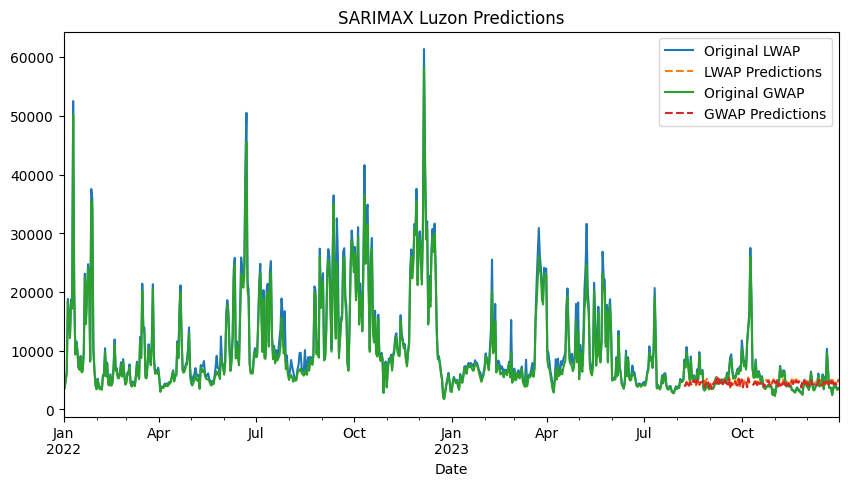

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
LWAP.plot(ax=ax, label='Original LWAP')
LWAP_predictions_inverse.plot(ax=ax, label='LWAP Predictions', linestyle='--')
GWAP.plot(ax=ax, label='Original GWAP')
GWAP_predictions_inverse.plot(ax=ax, label='GWAP Predictions', linestyle='--')
ax.set_title('SARIMAX Luzon Predictions')
ax.legend()
plt.show()

In [37]:
GWAP_predictions_inverse.to_csv('luz-gwap-predictions.csv', index=False)
LWAP_predictions_inverse.to_csv('luz-lwap-predictions.csv', index=False)